# About This Notebook

# Efficient Deep Active Learning (EDAL)

**In this notebook we will do several experiments related to the problem for efficient Active Learning. More precicely, we will consider Resenbrock2000D problem. As for acquisition function, we take Maximum Variance. For now, we will just use Gpytorch library, that provide us powefull and commputationally efficeint implementation of Gaussian Processes on Pytorch. We compare simple GP and GP with Neural Network. For predictive purposes, we will use LOVE method.**

<img src="EDAL.jpg">

# Note

**As I dont have enough computational power, I had to consider problem with less dimensionality (Rosenbrock20D)**

In [1]:
from matplotlib import image
from matplotlib.pyplot import imread
from IPython import display

import os
import time
import math
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.optimize import rosen

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import gpytorch

# Generating Data

In [2]:
np.random.seed(123)

num_train_points = 1000
num_test_points = 100
num_dims = 20

X = np.random.random((num_train_points, num_dims))
#y = rosen(X.T).reshape(-1, 1)
y = rosen(X.T)

X_train, X_query, y_train, y_query = train_test_split(X, y, test_size = 0.9)


X_test = np.random.random((num_test_points, num_dims))
y_test = rosen(X_test.T).reshape(-1, 1)

In [3]:
X_train.shape, y_train.shape, X_query.shape, y_query.shape, X_test.shape, y_test.shape

((100, 20), (100,), (900, 20), (900,), (100, 20), (100, 1))

In [4]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_query = torch.Tensor(X_query)
y_query = torch.Tensor(y_query)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

X_train.shape, y_train.shape, X_query.shape, y_query.shape, X_test.shape, y_test.shape

(torch.Size([100, 20]),
 torch.Size([100]),
 torch.Size([900, 20]),
 torch.Size([900]),
 torch.Size([100, 20]),
 torch.Size([100, 1]))

In [5]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
            )
            
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
def train():
    
    for i in range(training_iterations):
        
        optimizer.zero_grad()
        output = model(X_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()    
        
        # Then we print the results for this epoch:
        print('Iter %d/%d -MLL Loss: %.3f' % (i + 1, training_iterations, loss.item()))

# First Train 

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train, y_train, likelihood)

In [8]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 20

In [9]:
%time train()

Iter 1/20 -MLL Loss: 29224.348
Iter 2/20 -MLL Loss: 23368.119
Iter 3/20 -MLL Loss: 19026.561
Iter 4/20 -MLL Loss: 15837.443
Iter 5/20 -MLL Loss: 13481.152
Iter 6/20 -MLL Loss: 11713.499
Iter 7/20 -MLL Loss: 10360.667
Iter 8/20 -MLL Loss: 9302.833
Iter 9/20 -MLL Loss: 8458.027
Iter 10/20 -MLL Loss: 7770.067
Iter 11/20 -MLL Loss: 7199.867
Iter 12/20 -MLL Loss: 6719.903
Iter 13/20 -MLL Loss: 6310.382
Iter 14/20 -MLL Loss: 5956.862
Iter 15/20 -MLL Loss: 5648.568
Iter 16/20 -MLL Loss: 5377.352
Iter 17/20 -MLL Loss: 5136.939
Iter 18/20 -MLL Loss: 4922.389
Iter 19/20 -MLL Loss: 4729.797
Iter 20/20 -MLL Loss: 4556.024
CPU times: user 859 ms, sys: 12.2 ms, total: 871 ms
Wall time: 340 ms


In [10]:
# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    start_time = time.time()
    preds = model(X_query)
    exact_covar = preds.covariance_matrix
    exact_covar_time = time.time() - start_time

In [11]:
print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))

Time to compute exact mean + covariances: 0.15s


In [12]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(25):
    start_time = time.time()
    preds = model(X_test)
    fast_covar = preds.covariance_matrix
    fast_time_with_cache = time.time() - start_time

In [13]:
print('Time to compute mean + covariances (with cache) {:.2f}s'.format(fast_time_with_cache))

Time to compute mean + covariances (with cache) 0.02s


In [14]:
def Max_Variance_Query_Function(model, likelihood, q_batch, mode):
    
    # Set into eval mode
    model.eval()
    likelihood.eval()
    
    if mode == 'simple':
        with torch.no_grad():
            start_time = time.time()
            preds = model(X_query)
            exact_covar = preds.covariance_matrix
            exact_covar_time = time.time() - start_time
        return torch.sort(torch.diag(exact_covar), descending=True)[1][:q_batch], exact_covar_time   
    
    elif mode == 'fast':
        with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(500):
            start_time = time.time()
            preds = model(test_x)
            fast_covar = preds.covariance_matrix
            fast_covar_time_without_cashe = time.time() - start_time
        
        return torch.sort(torch.diag(fast_covar), descending=True)[1][:q_batch], fast_covar_time_without_cashe
    
    else:
        raise Exception("Check mode: simple or fast only")

# Active Learning

In [15]:
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)

X_query_copy = deepcopy(X_query)
y_query_copy = deepcopy(y_query)

In [16]:
X_train = deepcopy(X_train_copy)
y_train= deepcopy(y_train_copy)

X_query = deepcopy(X_query_copy)
y_query = deepcopy(y_query_copy)

# With descending = True, decompose parameter = 500

In [17]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train, y_train, likelihood)

In [18]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 20

In [19]:
%time train()

Iter 1/20 -MLL Loss: 29224.363
Iter 2/20 -MLL Loss: 23368.131
Iter 3/20 -MLL Loss: 19026.543
Iter 4/20 -MLL Loss: 15837.434
Iter 5/20 -MLL Loss: 13481.155
Iter 6/20 -MLL Loss: 11713.501
Iter 7/20 -MLL Loss: 10360.668
Iter 8/20 -MLL Loss: 9302.812
Iter 9/20 -MLL Loss: 8458.036
Iter 10/20 -MLL Loss: 7770.074
Iter 11/20 -MLL Loss: 7199.868
Iter 12/20 -MLL Loss: 6719.900
Iter 13/20 -MLL Loss: 6310.371
Iter 14/20 -MLL Loss: 5956.849
Iter 15/20 -MLL Loss: 5648.564
Iter 16/20 -MLL Loss: 5377.356
Iter 17/20 -MLL Loss: 5136.946
Iter 18/20 -MLL Loss: 4922.383
Iter 19/20 -MLL Loss: 4729.788
Iter 20/20 -MLL Loss: 4556.029
CPU times: user 844 ms, sys: 9.92 ms, total: 854 ms
Wall time: 313 ms


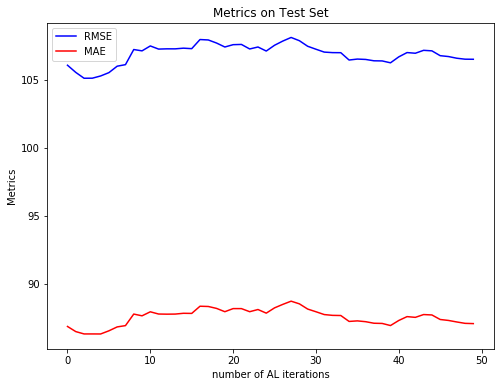

Epoch 50 of 50 took 5.121s
RMSE metrics: 	106.513756
MAE megrics: 	87.051537


In [21]:
budget = 50
q_batch = 10
mode = 'simple'
training_iterations = 60

times = []
rmse_metrics = []
mae_metrics = []

for budget_iter in range(0, budget):    
    
    al_start_time = time.time()
    
    if len(X_query) == 0:
        break
    
    # Get query points
    if q_batch < len(X_query):
        query_points, query_time = Max_Variance_Query_Function(model, likelihood, q_batch, mode)
    
    else:
        query_points, query_time = Max_Variance_Query_Function(model, likelihood, len(X_query), mode)

    
    times.append(query_time)
    
    # Add query_points to Train set
    X_train = torch.cat((X_train, X_query[query_points]), 0)
    y_train = torch.cat((y_train, y_query[query_points]), 0)
    
    # Delete points from Query Set
    # Is any opportunity to do it in anothe way?        
    mask = torch.ones(len(X_query), dtype=torch.uint8)
    mask[query_points] = 0
    X_query = X_query[mask, ...]
        
    
    # Creating model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(X_train, y_train, likelihood)
    
    # Training
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer 
    # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    train()
    
    # Calculate Covariance for test points using simple SKI
    
    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        preds = model(X_test)
        
    # calculate metrics
    rmse = torch.sqrt(torch.mean(torch.pow(preds.mean - y_test, 2)))
    rmse_metrics.append(rmse)
    
    
    mae = torch.mean(torch.abs(preds.mean - y_test))
    mae_metrics.append(mae)
    
    print('Test RMSE: {}'.format(rmse))
    print('Test MAE: {}'.format(mae))
    
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Metrics on Test Set")
    plt.xlabel("number of AL iterations")
    plt.ylabel("Metrics")
    #plt.yscale('log')
    plt.plot(rmse_metrics, 'b', label = "RMSE")
    plt.plot(mae_metrics, 'r', label = "MAE")
    plt.legend()
    plt.show()

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(budget_iter + 1, 
            np.minimum(math.ceil(len(X_query_copy) // q_batch), budget), 
            time.time() - al_start_time))
    print("RMSE metrics: \t{:.6f}".format(rmse_metrics[-1]))
    print("MAE megrics: \t{:.6f}".format(mae_metrics[-1]))
    
    # Save
    #torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')
    #np.save("train_loss_per_epoch", train_loss_per_epoch)
    #np.save("val_loss_per_epoch", val_loss_per_epoch)

# With descending = True, decompose parameter = 25

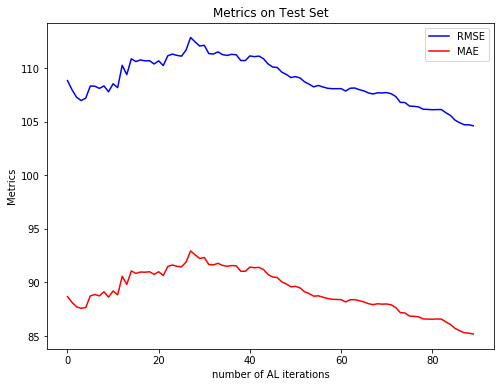

Epoch 90 of 90 took 5.625s
RMSE metrics: 	104.628372
MAE megrics: 	85.184891


In [17]:
budget = 1000
q_batch = 10
mode = 'simple'
training_iterations = 25

times = []
rmse_metrics = []
mae_metrics = []

for budget_iter in range(0, budget):    
    
    al_start_time = time.time()
    
    if len(X_query) == 0:
        break
    
    # Get query points
    if q_batch < len(X_query):
        query_points, query_time = Max_Variance_Query_Function(model, likelihood, q_batch, mode)
    
    else:
        query_points, query_time = Max_Variance_Query_Function(model, likelihood, len(X_query), mode)

    
    times.append(query_time)
    
    # Add query_points to Train set
    X_train = torch.cat((X_train, X_query[query_points]), 0)
    y_train = torch.cat((y_train, y_query[query_points]), 0)
    
    # Delete points from Query Set
    # Is any opportunity to do it in anothe way?
    #if q_batch < len(X_query):
    #    X_query = torch.Tensor()
    
    #else:
        #query_index_set = set(np.arange(len(X_query)))
        #query_points_set = set(query_points.numpy())
        
    mask = torch.ones(len(X_query), dtype=torch.uint8)
    mask[query_points] = 0
    X_query = X_query[mask, ...]
        
    
    # Creating model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(X_train, y_train, likelihood)
    
    # Training
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer 
    # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    train()
    
    # Calculate Covariance for test points using simple SKI
    
    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        preds = model(X_test)
        
    # calculate metrics
    rmse = torch.sqrt(torch.mean(torch.pow(preds.mean - y_test, 2)))
    rmse_metrics.append(rmse)
    
    
    mae = torch.mean(torch.abs(preds.mean - y_test))
    mae_metrics.append(mae)
    
    print('Test RMSE: {}'.format(rmse))
    print('Test MAE: {}'.format(mae))
    
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Metrics on Test Set")
    plt.xlabel("number of AL iterations")
    plt.ylabel("Metrics")
    #plt.yscale('log')
    plt.plot(rmse_metrics, 'b', label = "RMSE")
    plt.plot(mae_metrics, 'r', label = "MAE")
    plt.legend()
    plt.show()

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(budget_iter + 1, 
            np.minimum(math.ceil(len(X_query_copy) // q_batch), math.ceil(budget // q_batch)), 
            time.time() - al_start_time))
    print("RMSE metrics: \t{:.6f}".format(rmse_metrics[-1]))
    print("MAE megrics: \t{:.6f}".format(mae_metrics[-1]))
    
    # Save
    #torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')
    #np.save("train_loss_per_epoch", train_loss_per_epoch)
    #np.save("val_loss_per_epoch", val_loss_per_epoch)

# With descending = False, decompose parameter = 25

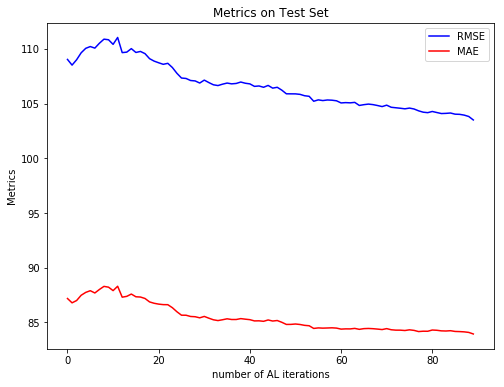

Epoch 90 of 90 took 5.298s
RMSE metrics: 	103.498032
MAE megrics: 	83.948875


In [17]:
budget = 1000
q_batch = 10
mode = 'simple'
training_iterations = 25

times = []
rmse_metrics = []
mae_metrics = []

for budget_iter in range(0, budget):    
    
    al_start_time = time.time()
    
    if len(X_query) == 0:
        break
    
    # Get query points
    if q_batch < len(X_query):
        query_points, query_time = Max_Variance_Query_Function(model, likelihood, q_batch, mode)
    
    else:
        query_points, query_time = Max_Variance_Query_Function(model, likelihood, len(X_query), mode)

    
    times.append(query_time)
    
    # Add query_points to Train set
    X_train = torch.cat((X_train, X_query[query_points]), 0)
    y_train = torch.cat((y_train, y_query[query_points]), 0)
    
    # Delete points from Query Set
    # Is any opportunity to do it in anothe way?
    #if q_batch < len(X_query):
    #    X_query = torch.Tensor()
    
    #else:
        #query_index_set = set(np.arange(len(X_query)))
        #query_points_set = set(query_points.numpy())
        
    mask = torch.ones(len(X_query), dtype=torch.uint8)
    mask[query_points] = 0
    X_query = X_query[mask, ...]
        
    
    # Creating model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(X_train, y_train, likelihood)
    
    # Training
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer 
    # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    train()
    
    # Calculate Covariance for test points using simple SKI
    
    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        preds = model(X_test)
        
    # calculate metrics
    rmse = torch.sqrt(torch.mean(torch.pow(preds.mean - y_test, 2)))
    rmse_metrics.append(rmse)
    
    
    mae = torch.mean(torch.abs(preds.mean - y_test))
    mae_metrics.append(mae)
    
    print('Test RMSE: {}'.format(rmse))
    print('Test MAE: {}'.format(mae))
    
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Metrics on Test Set")
    plt.xlabel("number of AL iterations")
    plt.ylabel("Metrics")
    #plt.yscale('log')
    plt.plot(rmse_metrics, 'b', label = "RMSE")
    plt.plot(mae_metrics, 'r', label = "MAE")
    plt.legend()
    plt.show()

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(budget_iter + 1, 
            np.minimum(math.ceil(len(X_query_copy) // q_batch), math.ceil(budget // q_batch)), 
            time.time() - al_start_time))
    print("RMSE metrics: \t{:.6f}".format(rmse_metrics[-1]))
    print("MAE megrics: \t{:.6f}".format(mae_metrics[-1]))
    
    # Save
    #torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')
    #np.save("train_loss_per_epoch", train_loss_per_epoch)
    #np.save("val_loss_per_epoch", val_loss_per_epoch)